In [1]:
import pathlib
import torch
from fastai.vision.all import *

In [2]:
import fastai
print("torch", torch.__version__, "fastai", fastai.__version__)

torch 2.5.1 fastai 2.7.18


In [12]:
from dotenv import load_dotenv
load_dotenv();
# print("PYTORCH_ENABLE_MPS_FALLBACK", os.getenv("PYTORCH_ENABLE_MPS_FALLBACK"))

In [13]:
# https://docs.fast.ai/tutorial.imagenette.html
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

def label_func(fname):
    return lbl_dict[parent_label(fname)]

In [5]:
def get_data__(url):
    path = untar_data(url)
    dblock = DataBlock(blocks=[ImageBlock, CategoryBlock],
                       get_items = get_image_files,
                       get_y = label_func,
                       splitter  = GrandparentSplitter(),
                       item_tfms = [RandomResizedCrop(128, min_scale=0.35)],
                       batch_tfms=Normalize.from_stats(*imagenet_stats)
                       )
    return dblock.dataloaders(path)


In [31]:
def get_data(url, presize, resize):
    path = untar_data(url)
    return DataBlock(
        blocks=[ImageBlock, CategoryBlock], get_items=get_image_files,
        splitter=GrandparentSplitter(valid_name='val'),
        get_y=label_func,
        #item_tfms=[Resize(presize)],
        item_tfms = [RandomResizedCrop(presize, min_scale=0.35)],
        batch_tfms=[*aug_transforms(min_scale=0.5, size=resize),
                    Normalize.from_stats(*imagenet_stats)],
    ).dataloaders(path, bs=128)

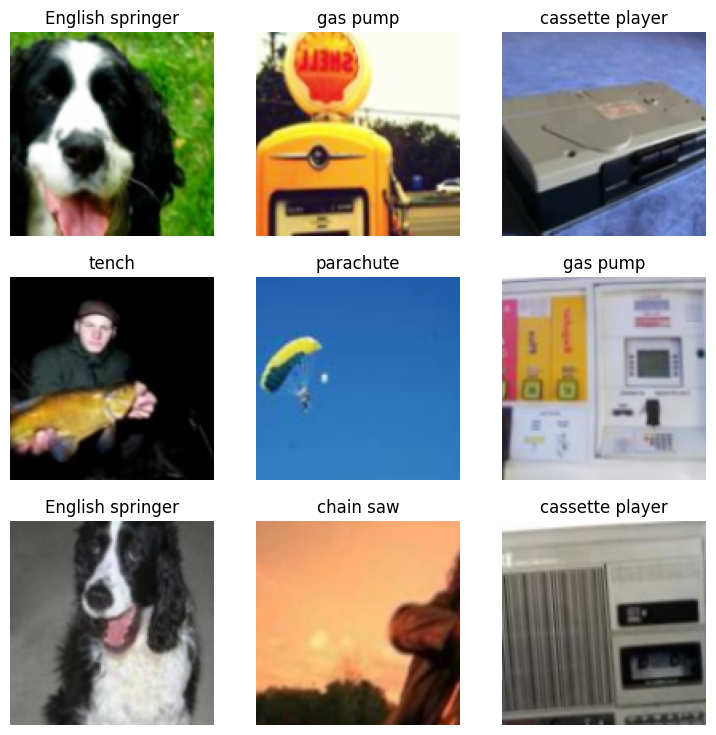

In [32]:
#dls = get_data(URLs.IMAGENETTE_160)
dls = get_data(URLs.IMAGENETTE_160, 160, 128)
dls.show_batch()

In [40]:
device=torch.device("mps")
# create a ResNet-34 without pretraining and pass along any arguments received
def get_learner(**kwargs):
    # learner = vision_learner(dls, resnet34, pretrained=False, metrics=accuracy)
    #learner = vision_learner(dls, resnet34, pretrained=False, metrics=accuracy, **kwargs)
    learner = Learner(dls, xresnet34(n_out=10), metrics=accuracy)

    # Explicitly move to device
    learner.model = learner.model.to(device)
    learner.dls.to(device)
    return learner

In [41]:
learn = get_learner()
print("Model device:", next(learn.model.parameters()).device)
print("Learner type:", type(learn))
print("Model type:", type(learn.model))

learn.fit_one_cycle(7, 1e-3)

Model device: mps:0
Learner type: <class 'fastai.learner.Learner'>
Model type: <class 'fastai.vision.models.xresnet.XResNet'>


epoch,train_loss,valid_loss,accuracy,time
0,1.883502,1.716611,0.438981,00:46
1,1.496937,1.601586,0.493758,00:45
2,1.269864,1.373453,0.547516,00:44
3,1.106592,1.137125,0.642038,00:44
4,0.964765,1.062092,0.654013,00:45
5,0.850343,0.858079,0.727898,00:46
6,0.795795,0.820334,0.738089,00:46


In [44]:
learn.fit_one_cycle(7, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.764938,0.813796,0.739108,00:47
1,0.750132,0.818616,0.734268,00:45
2,0.749069,0.840519,0.733758,00:45
3,0.720835,0.780647,0.751592,00:45
4,0.702144,0.765210,0.753376,00:45
5,0.686990,0.768655,0.753885,00:46
6,0.688113,0.770830,0.751592,00:45


SuggestedLRs(valley=1.737800812406931e-05)

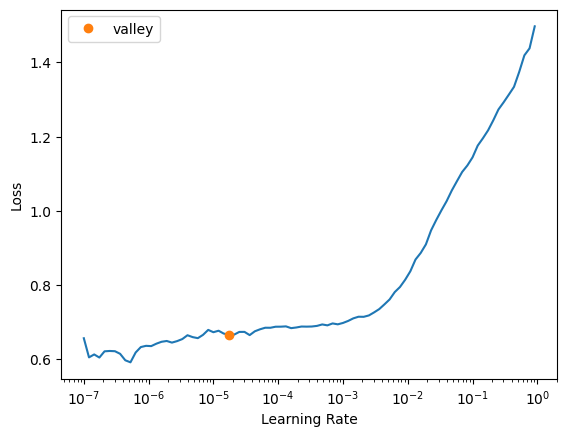

In [45]:
# find a good learning rate with the learning rate finder
learn.lr_find()

In [49]:
learn.save('/Users/ivostoyanov/.fastai/data/imagenette2-160/models/imaginette-xresnet34-160')

Path('/Users/ivostoyanov/.fastai/data/imagenette2-160/models/imaginette-xresnet34-160.pth')

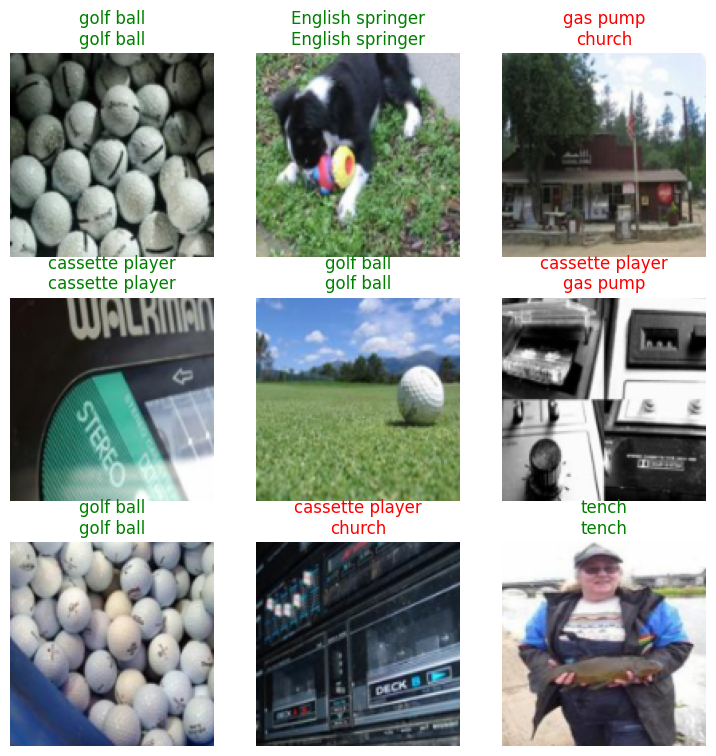

In [47]:
learn.show_results()

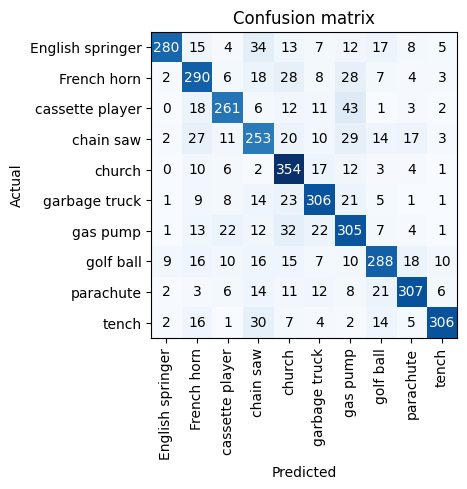

In [50]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

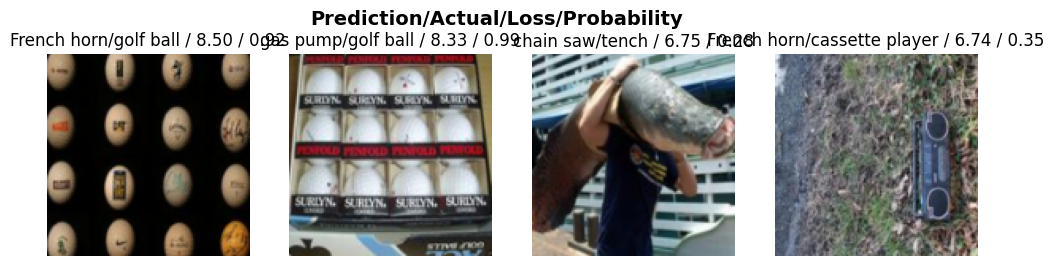

In [52]:
interp.plot_top_losses(4, nrows=1)

In [53]:
from fastai.vision.widgets import ImageClassifierCleaner

cleaner = ImageClassifierCleaner(learn)
cleaner